In [423]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree

In [424]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [425]:
#df0 = pd.read_csv('../spreadsheets/rlhf_1064.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # second Best 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_07rl.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv')
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_12rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_15rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_154nlp.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_19rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_23rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_157nlpgate.csv') # 0.25, 0.95, 0.01, 0.997, 0.999, 14000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000,
#df0 = pd.read_csv('../spreadsheets/rlhf_small_30rl.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_32rl.csv') # 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_33rl.csv')# 0.05, 0.85, 0.01, 0.997, 0.95, 4000
df0 = pd.read_csv('../spreadsheets/rlhf_small_36rl.csv')# 0.05, 0.85, 0.01, 0.997, 0.95, 4000

In [426]:
#!pip show numpy

In [427]:
#df0['action'] = df0['action'].replace('go_long', 'do_nothing')

In [428]:
df0.head()

,Unnamed: 0,sma-05 (entry),sma-07 (entry),sma-25 (entry),sma-compare (entry),is_short,action,imit-action,nlpreds,reward
0,0,0.502460,0.497686,0.488548,0,0,go_long,go_short,go_long,5.984069
1,1,0.181480,0.180829,0.178788,0,1,go_short,go_short,go_long,-5.372316
2,2,0.025259,0.025356,0.026236,1,0,go_long,go_long,go_long,4.147186
3,3,1.612120,1.603329,1.571272,0,0,go_long,go_short,go_long,4.228221
4,4,14.172400,14.174857,13.866320,0,0,go_long,go_short,go_long,1.886275


In [429]:
df0['nlpreds'].value_counts()

nlpreds
go_long     2170
go_short     335
Name: count, dtype: int64

In [430]:
#df0['imit-action'].value_counts()

In [431]:
df0['nlpreds'].value_counts()

nlpreds
go_long     2170
go_short     335
Name: count, dtype: int64

In [432]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [433]:
train_data = prep_data(df0)

In [434]:
train_data.head(2)

,Unnamed:,sma-05,sma-07,sma-25,sma-compare,is_short,action,imit-action,nlpreds,reward
0,0,0.50246,0.497686,0.488548,0,0,go_long,go_short,go_long,5.984069
1,1,0.18148,0.180829,0.178788,0,1,go_short,go_short,go_long,-5.372316


In [435]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["nlpreds"].map(action_mapping)

In [436]:
# Define RL parameters
states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [437]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [438]:
list_1 = [
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
]

list_2 = [
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
]

# Combine the lists and remove duplicates
combined_set = {tuple(sublist) for sublist in list_1 + list_2}

# Convert the set back to a list of lists
combined_list = [list(sublist) for sublist in combined_set]

# Print the combined list
for sublist in combined_list:
    print(sublist)

[0.25, 0.95, 1.0, 0.99, 0.99, 10000]


In [439]:
Hyperparameters = [
    [0.1, 0.9, 0.1, 0.99, 0.995, 4000],
    [0.005, 0.75, 0.1, 0.95, 0.999, 12000],
    [0.001, 0.75, 1.0, 0.99, 0.99, 30000],
    [1, 0.75, 0.005, 0.95, 0.95, 22000],
    [0.01, 0.99, 1.0, 0.95, 0.99, 16000],
    [0.7, 0.99, 1.0, 0.95, 0.997, 8000],
    [0.01, 0.95, 1.0, 0.997, 0.995, 26000],
    [0.25, 0.95, 0.01, 0.997, 0.999, 14000],
    [0.5, 0.85, 0.5, 0.997, 0.997, 14000],
    [0.01, 0.85, 0.01, 0.95, 0.95, 12000],
    [0.9, 0.99, 0.5, 0.995, 0.95, 12000],
    [0.05, 0.9, 0.5, 0.95, 0.999, 4000],
    [0.05, 0.99, 0.5, 0.99, 0.997, 6000],
    [1, 0.75, 0.05, 0.999, 0.999, 10000],
    [0.9, 0.95, 1.0, 0.99, 0.99, 8000],
    [0.25, 0.75, 0.01, 0.995, 0.999, 20000],
    [0.3, 0.75, 1.0, 0.995, 0.99, 10000],
    [1, 0.9, 1.0, 0.999, 0.999, 10000],
    [0.7, 0.75, 1.0, 0.97, 0.999, 28000],
    [0.05, 0.95, 1.0, 0.999, 0.995, 12000],
    [0.7, 0.95, 0.5, 0.999, 0.99, 16000],
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
    [0.25, 0.99, 0.01, 0.997, 0.99, 8000],
    [1, 0.95, 0.1, 0.96, 0.96, 12000],
    [0.9, 0.9, 0.005, 0.95, 0.999, 10000],
    [0.05, 0.85, 0.01, 0.997, 0.95, 4000]


]

'''
alpha = 0.7
gamma = 0.75
epsilon = 1.0
min_epsilon = 0.97
decay_rate = 0.97
n_episodes = 28000
n_states = states.shape[0]  # Number of states
n_actions = len(actions)  # Number of actions
'''
alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = Hyperparameters[5] # Hyperparameters[21]


In [440]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['sma-05'], row['sma-07'], row['sma-25'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('small_state_to_index.npy', state_to_index)


In [441]:

# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action


In [442]:
'''
# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 1000 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("small_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()
'''

'\n# Set random seed for reproducibility and train the loop\nnp.random.seed(42)\nrandom.seed(42)\n# Initialize a list to store rewards per episode\nrewards_per_episode = []\n\nfor episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):\n    current_state = np.random.randint(0, n_states)  # Random initial state\n    total_reward = 0  # Initialize total reward for the current episode\n\n    while current_state < n_states - 1:\n        action = choose_action(current_state, epsilon)\n        \n        next_state = current_state + 1  # This depends on your environment logic\n        reward = rewards[next_state]\n\n        best_next_action = np.argmax(q_table[next_state])\n        q_table[current_state, action] += alpha * (\n            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]\n        )\n        \n        total_reward += reward  # Accumulate reward for the current episode\n        current_state = next_state  # Move to nex

In [443]:
# Simplified environment function
def environment_step(current_state, action):
    """
    Simulates the environment's response to an action.
    
    Args:
        current_state (int): The current state of the environment.
        action (int): The action taken by the agent.
    
    Returns:
        next_state (int): The next state after taking the action.
        reward (float): The reward received after taking the action.
    """
    # Define the environment logic here
    next_state = current_state + 1  # Example: Move to the next state
    reward = rewards[next_state]    # Example: Reward is based on the next state
    
    return next_state, reward

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Initialize a list to store rewards per episode
rewards_per_episode = []

# Training loop
for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        # Use the environment function to get the next state and reward
        next_state, reward = environment_step(current_state, action)

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 800 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("small_q_table.npy", q_table)

evaluating results per episode ...:   0%|          | 13/8000 [00:00<01:04, 123.26it/s]

Episode 0/8000 - Total Reward: -1835.2951134899984, Epsilon: 0.997


evaluating results per episode ...:  10%|█         | 820/8000 [00:06<01:02, 114.17it/s]

Episode 800/8000 - Total Reward: -3709.611868039993, Epsilon: 0.95


evaluating results per episode ...:  20%|██        | 1622/8000 [00:12<00:50, 126.91it/s]

Episode 1600/8000 - Total Reward: 766.4187404299995, Epsilon: 0.95


evaluating results per episode ...:  30%|███       | 2422/8000 [00:19<00:51, 109.04it/s]

Episode 2400/8000 - Total Reward: 806.3781415799994, Epsilon: 0.95


evaluating results per episode ...:  40%|████      | 3227/8000 [00:25<00:34, 139.20it/s]

Episode 3200/8000 - Total Reward: 668.8249095999996, Epsilon: 0.95


evaluating results per episode ...:  50%|█████     | 4015/8000 [00:31<00:34, 114.97it/s]

Episode 4000/8000 - Total Reward: 739.7775658999998, Epsilon: 0.95


evaluating results per episode ...:  60%|██████    | 4820/8000 [00:38<00:24, 128.99it/s]

Episode 4800/8000 - Total Reward: 421.3456069000006, Epsilon: 0.95


evaluating results per episode ...:  70%|███████   | 5614/8000 [00:44<00:19, 120.42it/s]

Episode 5600/8000 - Total Reward: -101.15944664000082, Epsilon: 0.95


evaluating results per episode ...:  80%|████████  | 6415/8000 [00:50<00:11, 132.12it/s]

Episode 6400/8000 - Total Reward: -4725.606905659993, Epsilon: 0.95


evaluating results per episode ...:  90%|█████████ | 7220/8000 [00:57<00:05, 132.92it/s]

Episode 7200/8000 - Total Reward: 232.7245574499997, Epsilon: 0.95


evaluating results per episode ...: 100%|██████████| 8000/8000 [01:03<00:00, 126.57it/s]


In [444]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="small_state_to_index.npy")
loaded_qtable = load_q_table(file_path="small_q_table.npy")

In [445]:
def prep_state(sma_05: float, sma_07: float, sma_25: float, sma_compare: int, is_short: int):
    state = np.array([[sma_05, sma_07, sma_25, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state



In [446]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action


In [447]:
# Example usage:
with open("small_q_table.npy", "rb") as f:
    q_table = load_q_table("small_q_table.npy")

with open("small_state_to_index.npy", "rb") as f:
    state_to_index = load_state_index_mapping("small_state_to_index.npy")

In [448]:
X = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values
state_1 = list(X[-1:].flatten()) # sample: [[0.87024    0.85277143 0.779504   0.         1.        ]]

state = prep_state(*state_1)
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}


In [449]:
try:
    predicted_action = predict_action(state, q_table, state_to_index, action_mapping)
    print(f"The predicted action for the state is: {predicted_action}")
except ValueError as e:
    print(e)
    print("The state is not found in the state index mapping.")

The predicted action for the state is: go_long


In [450]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values
    action = predict_action(state, q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [451]:
train_data.head(15)

,Unnamed:,sma-05,sma-07,sma-25,sma-compare,is_short,action,imit-action,nlpreds,reward,action_num,predicted_action
0,0,0.502460,0.497686,0.488548,0,0,go_long,go_short,go_long,5.984069,0,do_nothing
1,1,0.181480,0.180829,0.178788,0,1,go_short,go_short,go_long,-5.372316,0,do_nothing
2,2,0.025259,0.025356,0.026236,1,0,go_long,go_long,go_long,4.147186,0,do_nothing
3,3,1.612120,1.603329,1.571272,0,0,go_long,go_short,go_long,4.228221,0,go_short
4,4,14.172400,14.174857,13.866320,0,0,go_long,go_short,go_long,1.886275,0,go_short
5,5,3.439160,3.407986,3.334664,0,0,go_long,go_short,go_long,4.486469,0,go_long
6,6,0.580220,0.577871,0.564268,0,0,go_long,go_short,go_long,4.802110,0,go_short
7,7,0.999300,0.993443,0.977384,0,0,go_long,go_short,go_long,1.097025,0,go_long
8,8,634.142000,638.405714,647.532400,1,0,go_long,go_short,go_long,2.375761,0,do_nothing
9,9,0.540400,0.539000,0.527440,0,0,go_long,go_short,go_long,-0.420655,0,go_short


In [452]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       1540
go_short       489
do_nothing     476
Name: count, dtype: int64

In [453]:
m = train_data[(train_data['nlpreds'] == 'go_short') & (train_data['reward'] > 0)]

In [454]:
m['is_short'].value_counts()

is_short
1    166
0      2
Name: count, dtype: int64

In [455]:
s = df0[(df0['reward'] > 0)]
s['nlpreds'].value_counts()

nlpreds
go_long     1070
go_short     168
Name: count, dtype: int64

In [456]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)

print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/2504
Current Predicted Reward: 0
Current Actual Reward: -5.37231572
Processed state 100/2504
Current Predicted Reward: 303.23515544
Current Actual Reward: 1080.5410523199998
Processed state 200/2504
Current Predicted Reward: 692.34382102
Current Actual Reward: 2310.652637359999
Processed state 300/2504
Current Predicted Reward: 1862.6532551700006
Current Actual Reward: 3550.5854586099986
Processed state 400/2504
Current Predicted Reward: 2770.7781411100013
Current Actual Reward: 4798.93971933
Processed state 500/2504
Current Predicted Reward: 3107.996669340001
Current Actual Reward: 6041.297320040003
Processed state 600/2504
Current Predicted Reward: 3456.5634272800003
Current Actual Reward: 7138.83253316
Processed state 700/2504
Current Predicted Reward: 3186.7944195600007
Current Actual Reward: 6326.089369459994
Processed state 800/2504
Current Predicted Reward: 2594.980050100001
Current Actual Reward: 4634.717703039992
Processed state 900/2504
Current Predicted Rew

In [457]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 61.84%


In [458]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1433  373  364]
 [ 107  116  112]
 [   0    0    0]]


In [468]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == action) & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total_reward': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%'
    }

In [469]:
print(action_reward('go_short', 1)) # go_short 1

{'counts': 126, 'total_reward': -148.67104949000012, 'winrate': '49.21%'}


In [461]:
m = m[m['is_short'] == 0]
m['reward'].cumsum()[-1:]

1334    3.629589
Name: reward, dtype: float64

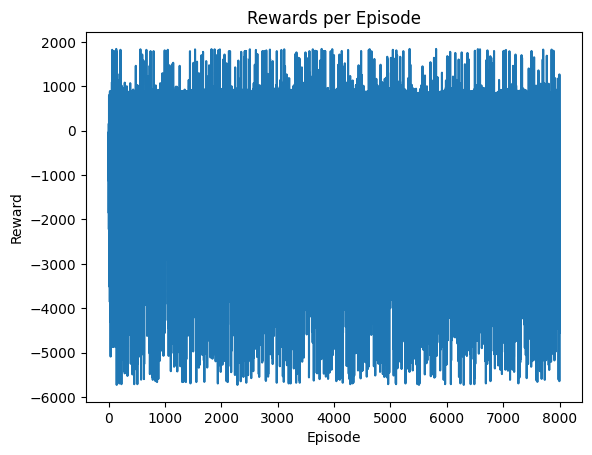

In [462]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [463]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate)

    return q_table, rewards_per_episode


In [464]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    for state_index in range(n_states):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [465]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [466]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.96, 0.97, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 18000, 21000, 24000, 28000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")
'''


'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [467]:
'''
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}

# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_pred_reward\n        